# Classification Tree and Random Forest

In [447]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve

from sklearn.inspection import permutation_importance

from sklearn.tree import plot_tree, DecisionTreeClassifier

In [448]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [449]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [450]:
# Create X matrix of regressor variables
X = df.drop(['DEATH_EVENT'], axis = 1)

In [451]:
# Create y vector of regressand variable DEATH_EVENT
y = df['DEATH_EVENT']

In [452]:
ratio_death = df[df["DEATH_EVENT"] == 1].DEATH_EVENT.sum() / df.DEATH_EVENT.count()
print(f"Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: {ratio_death}")

Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: 0.3210702341137124


In [453]:
##split
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='time'), y , test_size=0.30, random_state=3)

##standardize (around 71% acc on val set)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)




# Classification Tree

In [454]:
ct_2 = DecisionTreeClassifier(max_depth=2)

In [455]:
ct = DecisionTreeClassifier()

In [456]:
ct_2.fit(X_train_sc, y_train)
ct.fit(X_train_sc, y_train)

DecisionTreeClassifier()

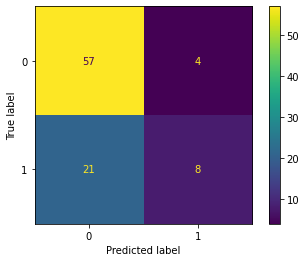

In [457]:
plot_confusion_matrix(ct_2, X_test_sc, y_test);

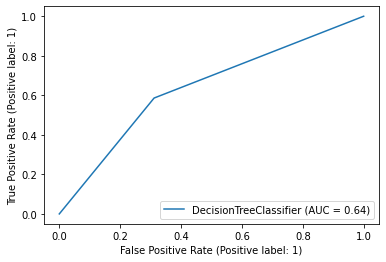

In [458]:
plot_roc_curve(ct, X_test_sc, y_test);

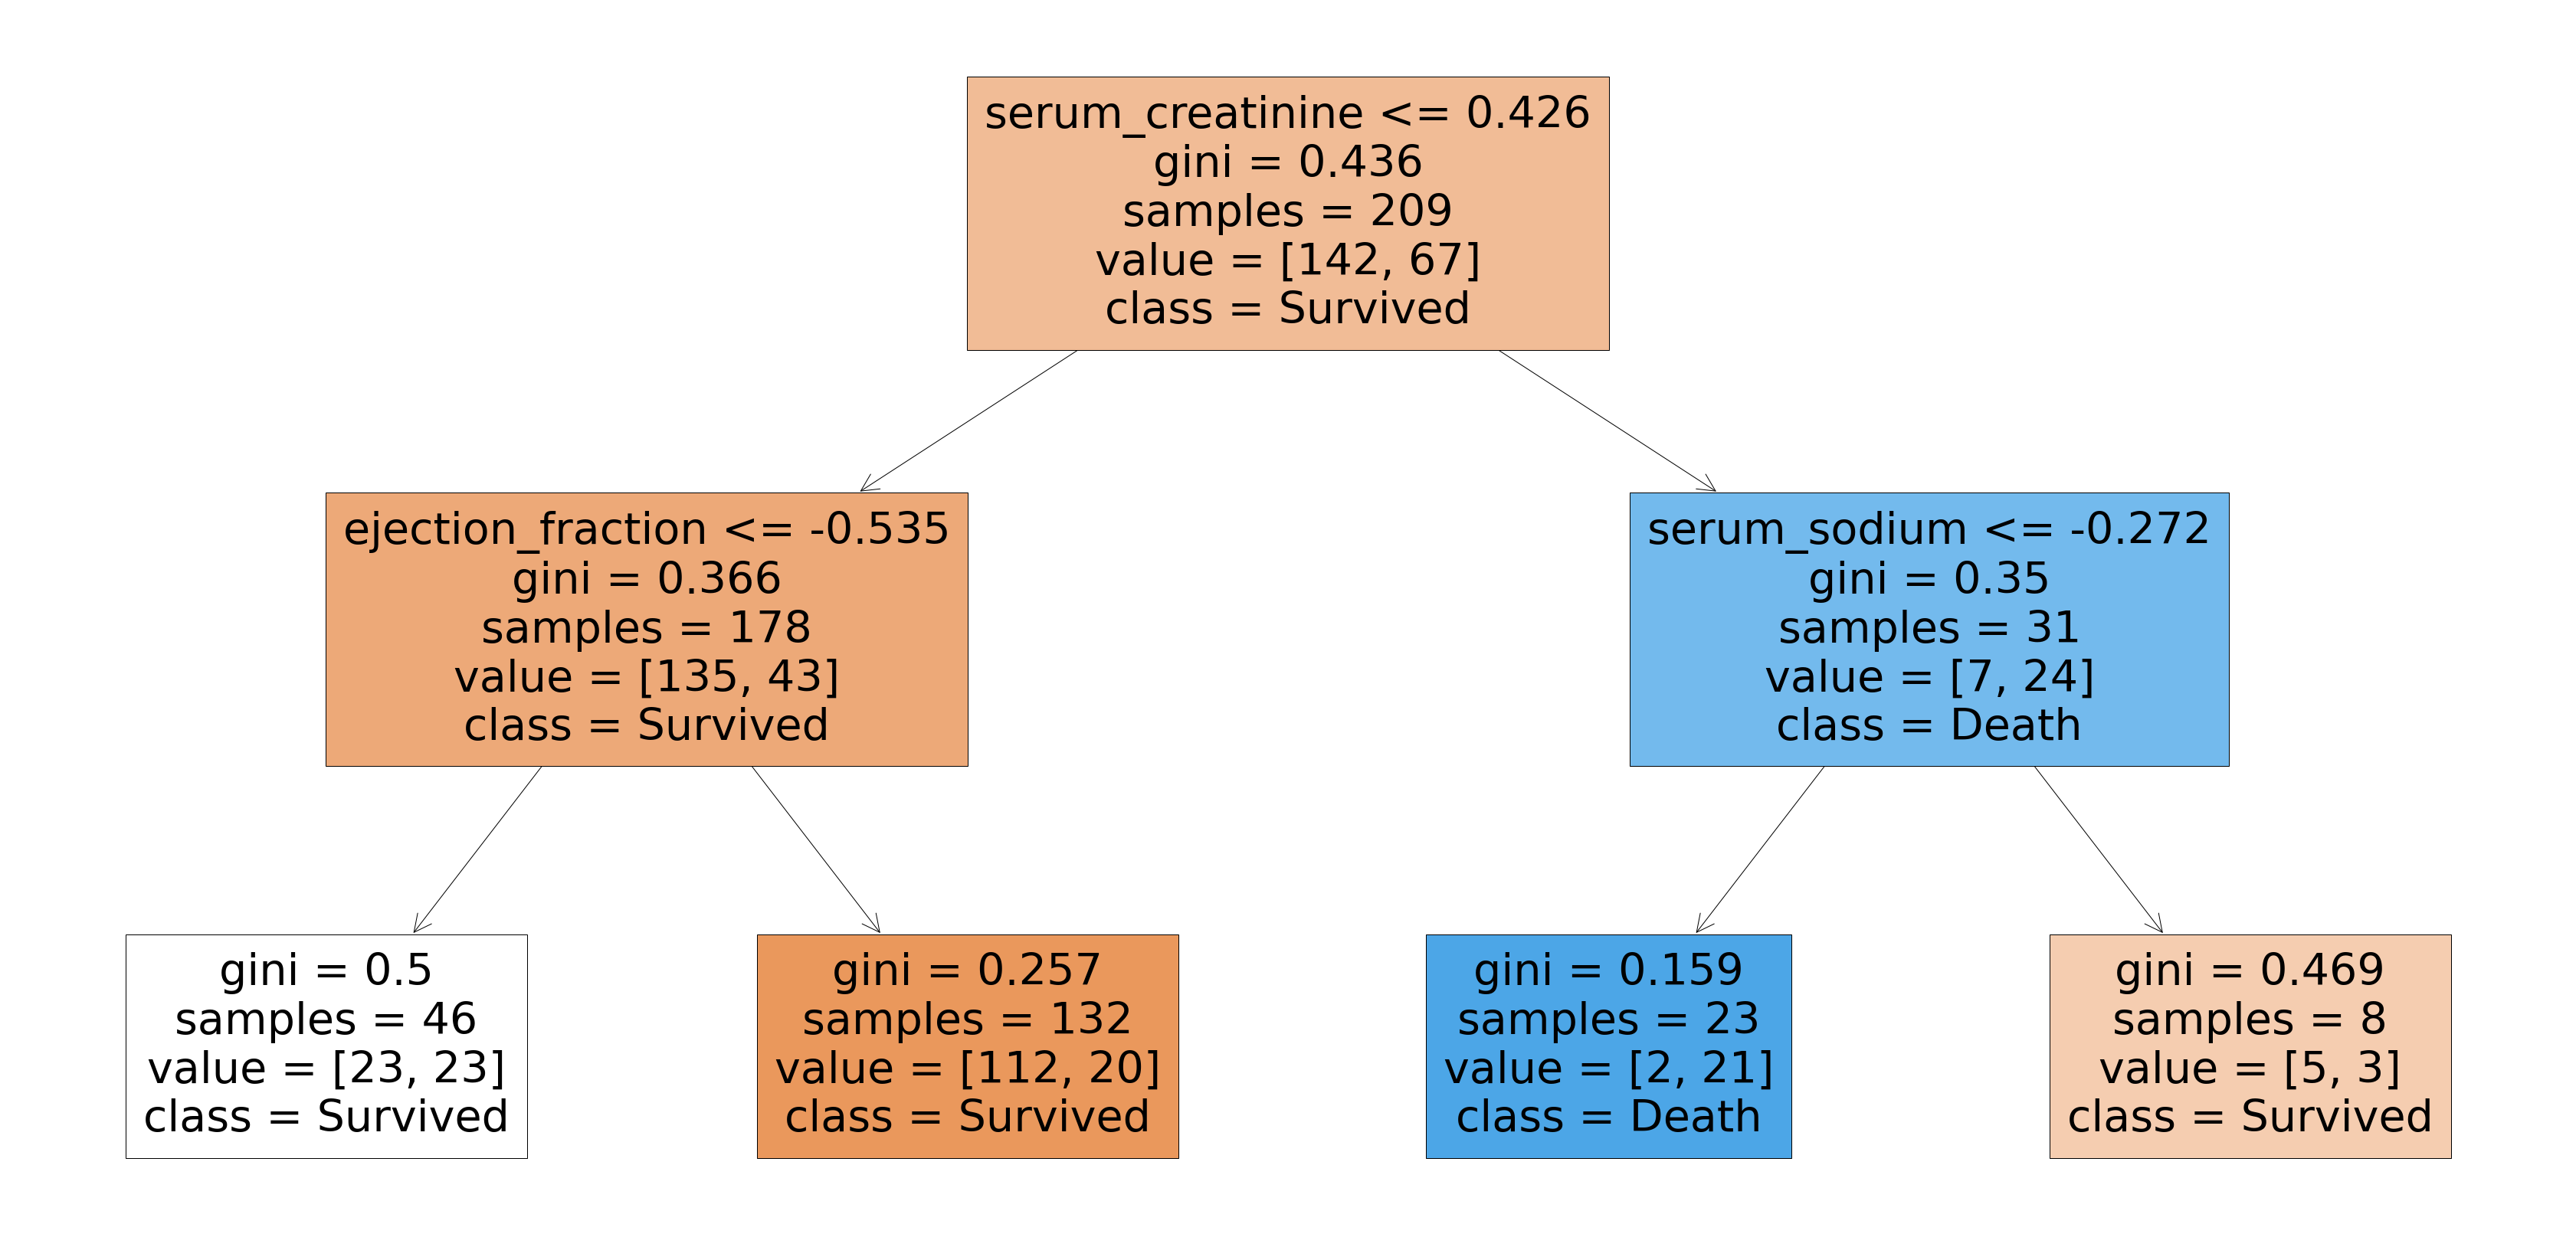

In [459]:
plt.figure(figsize=(60,30))
plot_tree(ct_2, feature_names = X.columns,class_names=['Survived', "Death"],filled=True);

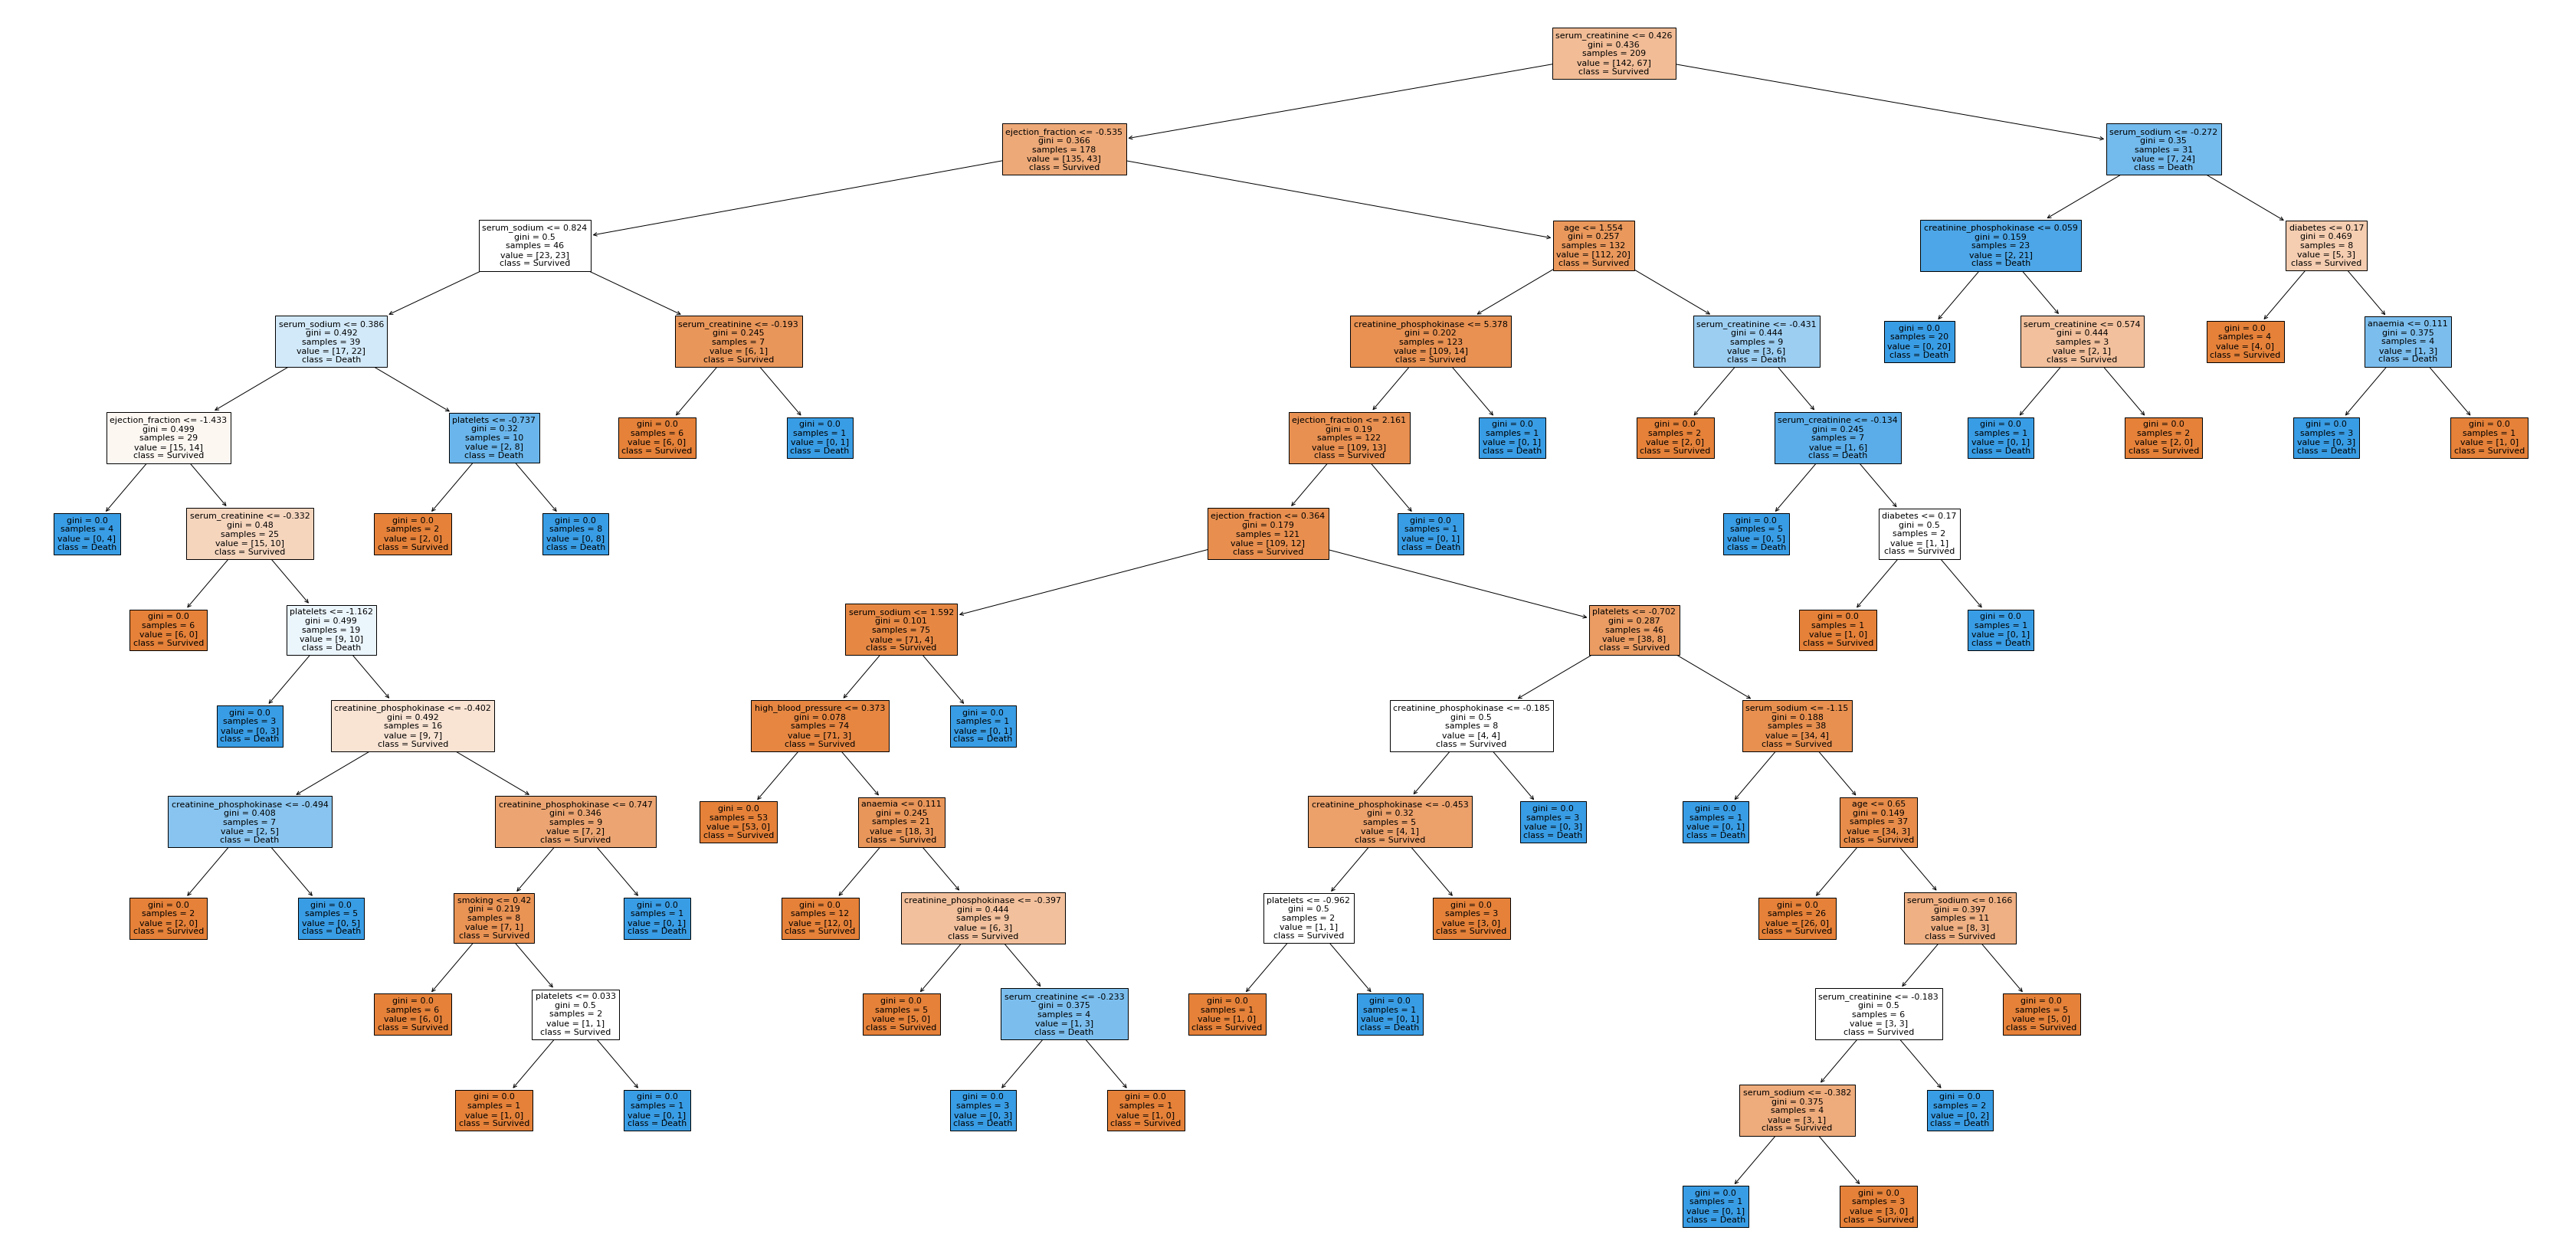

In [460]:
plt.figure(figsize=(60,30))
plot_tree(ct, feature_names = X.columns,class_names=['Survived', "Death"],filled=True);

# Random Forest

### 1. Durchgang: Ursprüngliche Daten (standardisiert)

In [461]:
rf = RandomForestClassifier()

In [462]:
rf.fit(X_train_sc, y_train)

RandomForestClassifier()

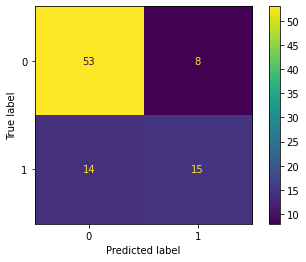

In [463]:
plot_confusion_matrix(rf, X_test_sc, y_test);

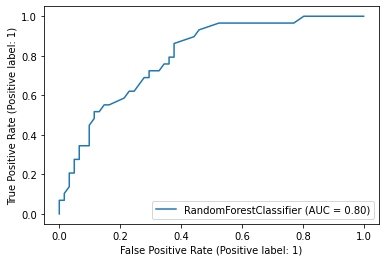

In [464]:
plot_roc_curve(rf, X_test_sc, y_test);

### 2. Durchgang: SMOTE Upsampling Daten

In [465]:
#Experiment: SMOTE UPSAMLING

oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train_sc, y_train)

print(f"Neues Verhältnis nach SMOTE Anwendung:{y_train_sm[y_train_sm == 1].sum() / len(y_train_sm)}")


Neues Verhältnis nach SMOTE Anwendung:0.5


In [466]:
rf_sm = RandomForestClassifier()
rf_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

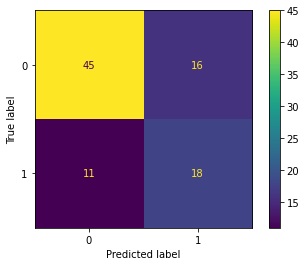

In [467]:
plot_confusion_matrix(rf_sm, X_test_sc, y_test);

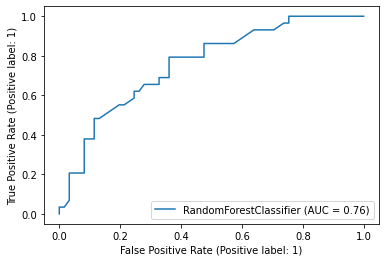

In [468]:
plot_roc_curve(rf_sm, X_test_sc, y_test);

### 3. Durchgang: PCA Daten

In [469]:
pca = PCA(n_components=5)
X_train_pca = pd.DataFrame(data = pca.fit_transform(X_train_sc), columns=['pc1','pc2','pc3','pc4','pc5'])
X_test_pca = pd.DataFrame(data = pca.transform(X_test_sc), columns=['pc1','pc2','pc3','pc4','pc5'])

In [470]:
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

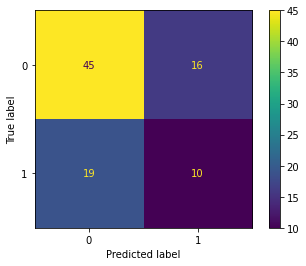

In [471]:
plot_confusion_matrix(rf_pca, X_test_pca, y_test);

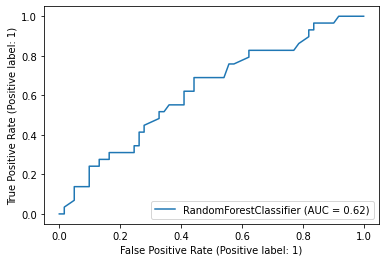

In [472]:
plot_roc_curve(rf_pca, X_test_pca, y_test);

### 4. Durchgang: Beste Datengrundlage und Hyperparameter Tuning

In [473]:
params = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': [2,3,4],
    'n_estimators': [30, 50, 100, 200, 300]
}

In [ ]:
rf_tune = RandomForestClassifier()
rf_tune = GridSearchCV(rf_tune, params, cv=2, scoring = "roc_auc")
rf_tune.fit(X_train_sc,y_train)

In [ ]:
print(rf_tune.best_params_)
print(rf_tune.best_estimator_)

In [ ]:
plot_confusion_matrix(rf_tune, X_test_sc, y_test);

### Final Evaluation using ROC-AUC Curve & Score

In [ ]:
plot_roc_curve(rf_tune, X_test_sc, y_test);

In [ ]:
plt.figure(figsize=(20,10))

# perform permutation importance
results = permutation_importance(rf_tune, X_test_sc, y_test, scoring='roc_auc')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print(f'{X_test.columns[i]}, Score: {np.round(v, decimals=4)}')
# plot feature importance
plt.bar(X_test.columns, importance)
plt.xlabel("Features")
plt.show()